In [5]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [8]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [9]:
DATASET_ID = 'BIRD_DB_Vireo_cassinii'

In [10]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [11]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins.pickle'
df_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/syllable_dfs/BIRD_DB_Vireo_cassinii/cassins.pickle')

In [12]:
syllable_df = pd.read_pickle(df_loc)

In [13]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4..."
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236..."
2,74.130176,74.376012,bz,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.0889848557398444, -0.06770700742932487, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2822944, 0.0..."


In [14]:
len(syllable_df)

67032

In [15]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### cluster

In [16]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [17]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [18]:
import hdbscan

In [19]:
from avgn.visualization.projections import draw_projection_transitions

In [22]:
syllable_df = syllable_df.sort_values(by=["key", "start_time"])
print(len(syllable_df))
specs = [norm(i) for i in syllable_df.spectrogram.values]

# sequencing
syllable_df["syllables_sequence_id"] = None
syllable_df["syllables_sequence_pos"] = None
for ki, key in enumerate(syllable_df.key.unique()):
    syllable_df.loc[syllable_df.key == key, "syllables_sequence_id"] = ki
    syllable_df.loc[syllable_df.key == key, "syllables_sequence_pos"] = np.arange(
        np.sum(syllable_df.key == key)
    )

67032


In [23]:
# umap
specs_flattened = flatten_spectrograms(specs)
cuml_umap = cumlUMAP(min_dist=0.5)
z = list(cuml_umap.fit_transform(specs_flattened))
syllable_df["umap"] = z

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  after removing the cwd from sys.path.


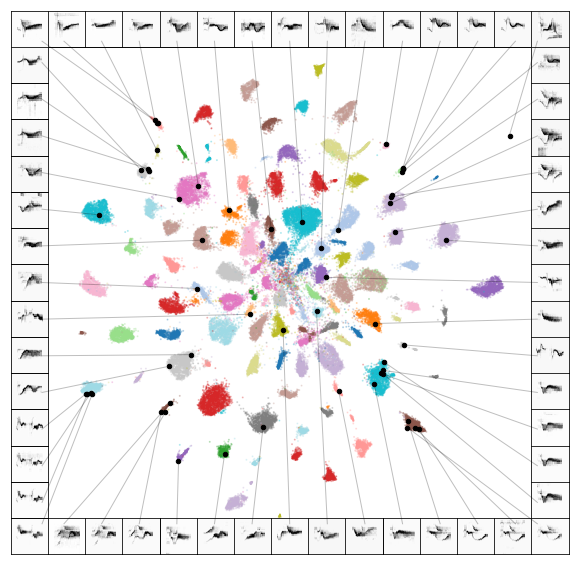

In [25]:
# plot
scatter_spec(
    np.vstack(z),
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': list(syllable_df.labels.values),
        'alpha':0.25,
        's': 1,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True,
    #ax= ax[0,indvi]
);

In [1]:
draw_projection_transitions(
    projections=np.array(list(syllable_df['umap'].values)),
    sequence_ids=syllable_df["syllables_sequence_id"],
    sequence_pos=syllable_df["syllables_sequence_pos"],
    #ax=ax[1,indvi],
    alpha = 0.0025
)

NameError: name 'draw_projection_transitions' is not defined

### label

In [28]:
from sklearn.cluster import MiniBatchKMeans

In [31]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(len(z) * 0.001), # the smallest size we would expect a cluster to be
    min_samples=1, # larger values = more conservative clustering
)
clusterer.fit(z);
syllable_df['hdbscan_labels'] = clusterer.labels_

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [ ]:
# HDBSCAN 
specs = [norm(i) for i in syllable_df.spectrogram.values]
specs_flattened = flatten_spectrograms(specs)

In [ ]:
# kmeans
# get number of possible states
n_states = len(syllable_df.labels.unique())

kmeans = MiniBatchKMeans(n_clusters = n_states).fit(z)
syllable_df['kmeans_labels'] = kmeans.labels_

In [ ]:
# kmeans data
kmeans = MiniBatchKMeans(n_clusters = n_states).fit(specs_flattened)
syllable_df['kmeans__pix_labels'] = kmeans.labels_

### plot

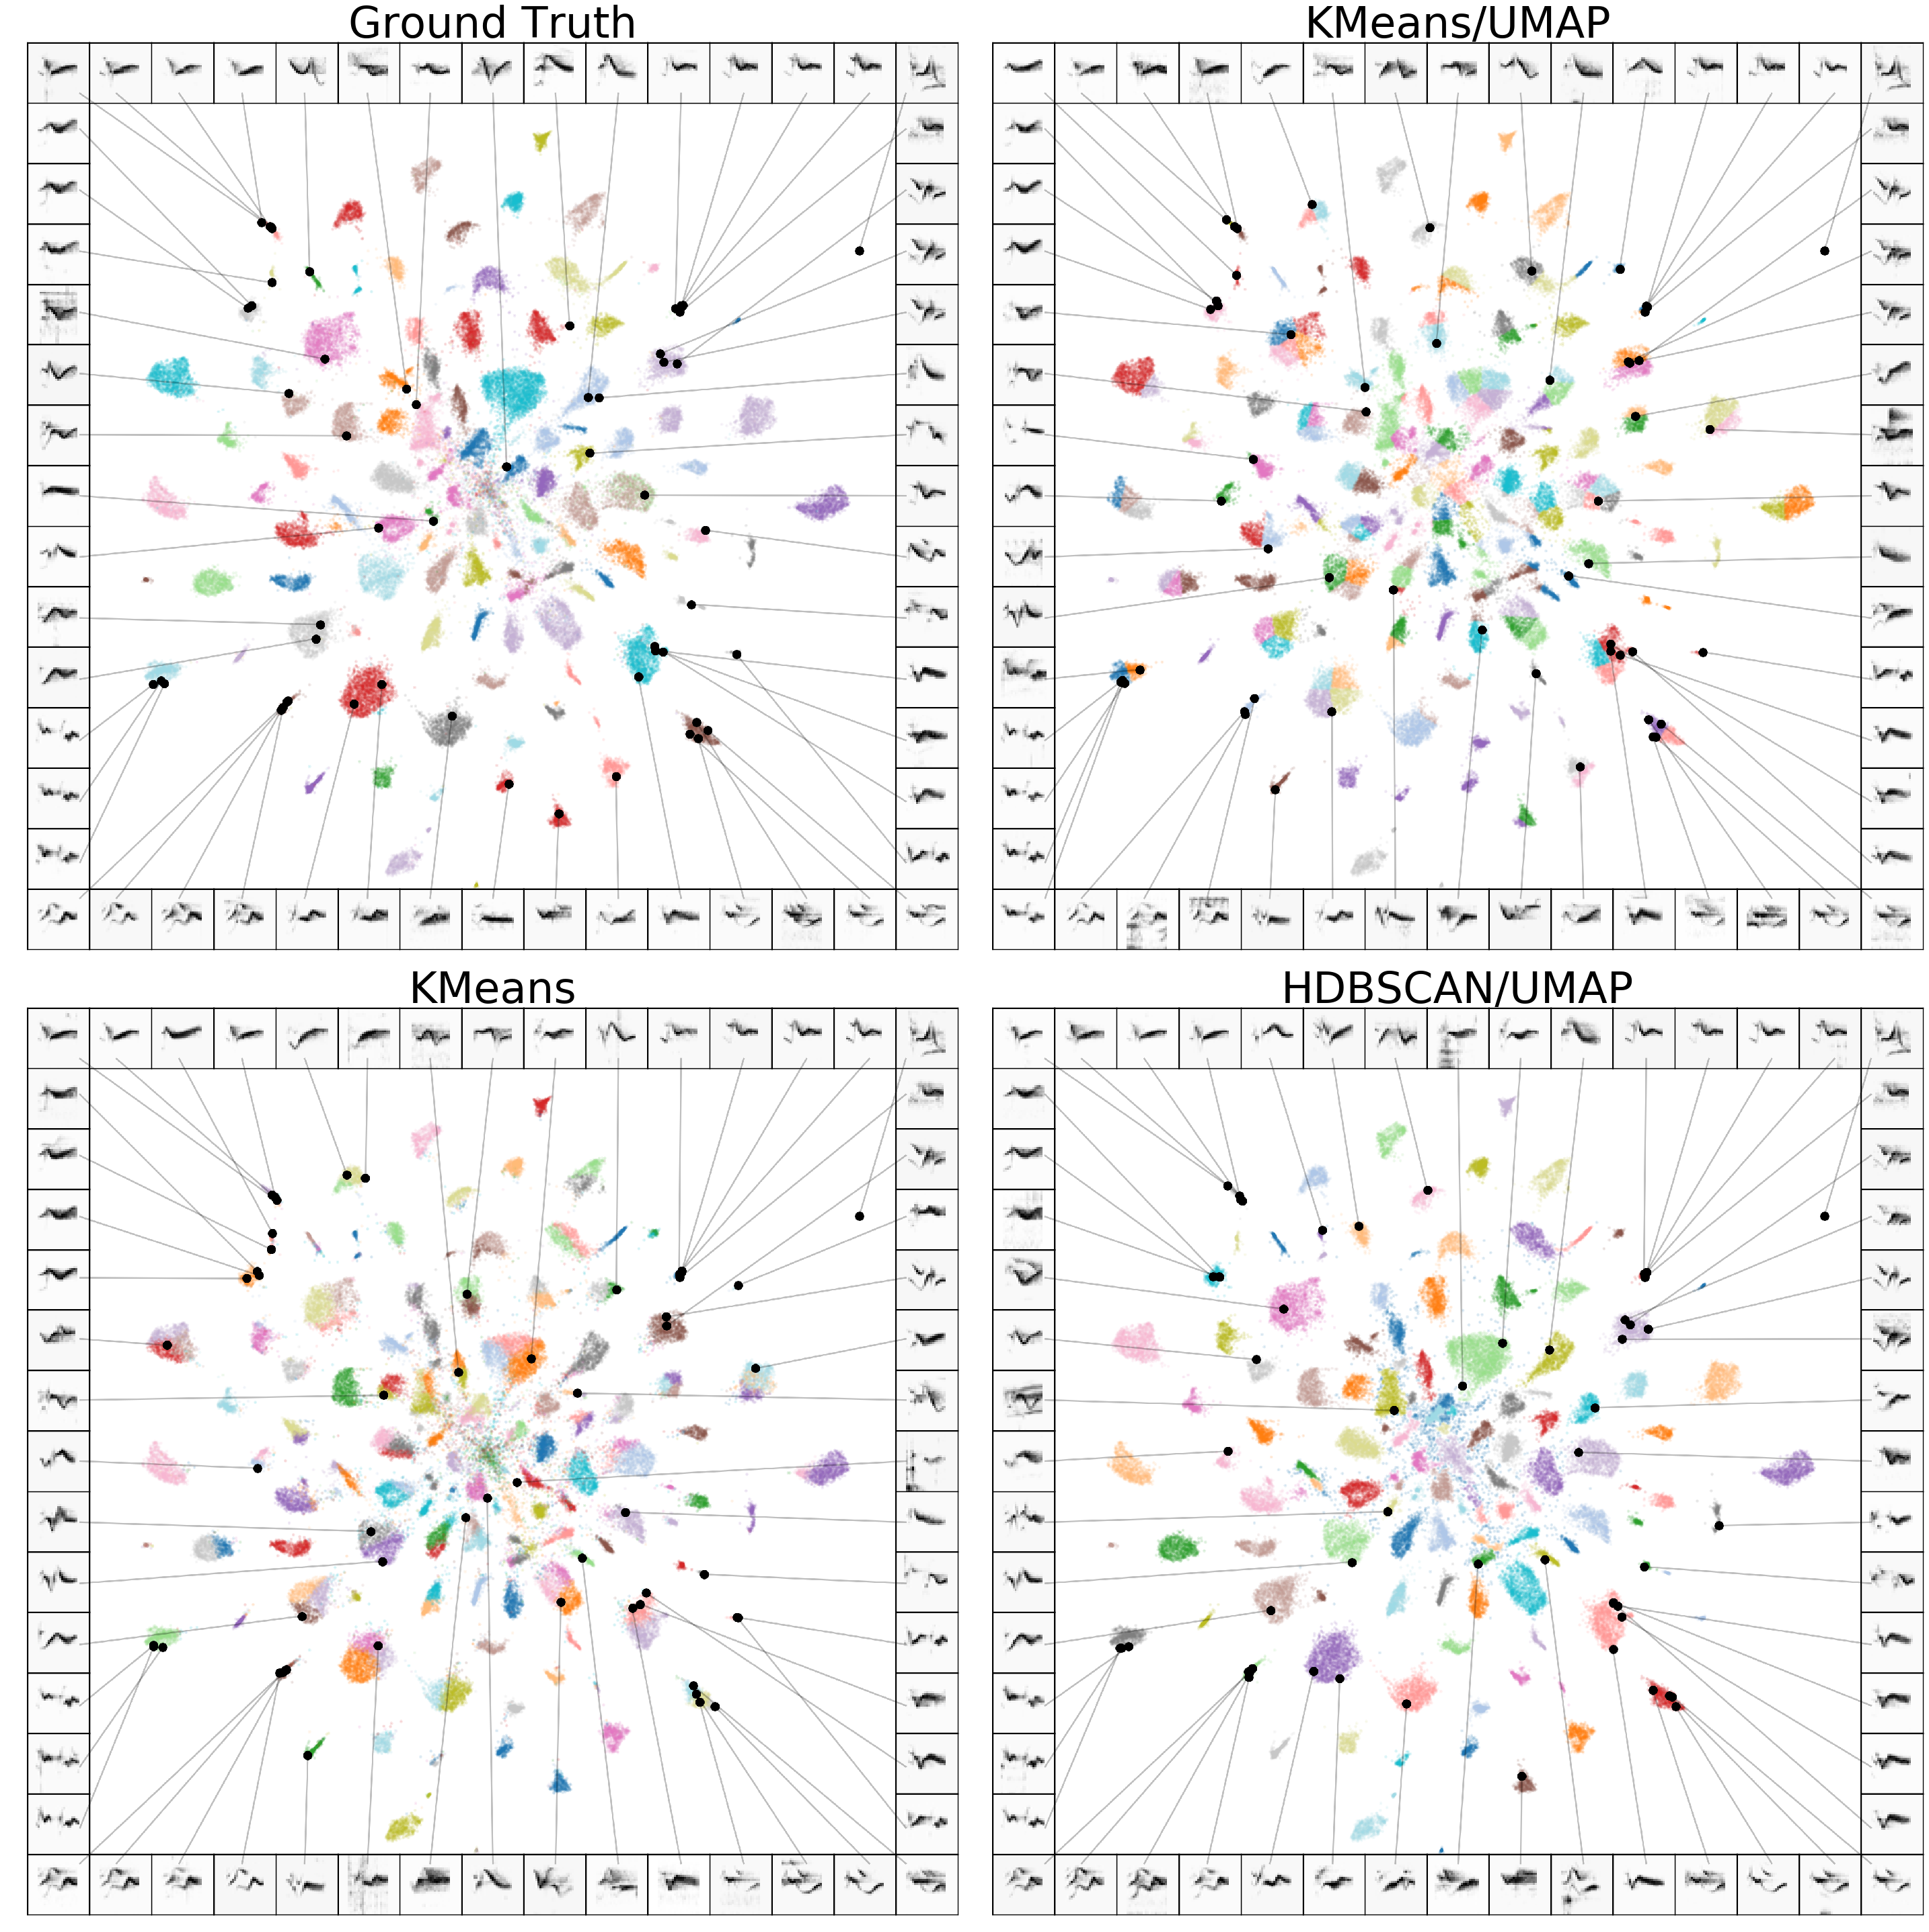

In [46]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(40, 40))
"""draw_projection_transitions(
    projections=np.array(list(syllable_df["umap"].values)),
    sequence_ids=syllable_df["syllables_sequence_id"],
    sequence_pos=syllable_df["syllables_sequence_pos"],
    ax=axs[0],
)"""

for i, (lablab, lab) in enumerate(
    tqdm([
        ["Ground Truth", "labels"],
        ['KMeans/UMAP',"kmeans_labels"],
        ["KMeans" , "kmeans__pix_labels"],
        ["HDBSCAN/UMAP", "hdbscan_labels"],
    ]
)):
    ax = axs.flatten()[i]
    scatter_spec(
        np.array(list(syllable_df["umap"].values)),
        specs = syllable_df.spectrogram.values,
        column_size=15,
        # x_range = [-5.5,7],
        # y_range = [-10,10],
        pal_color="hls",
        color_points=False,
        enlarge_points=20,
        figsize=(10, 10),
        scatter_kwargs={
            "labels": list(syllable_df[lab].values),
            "alpha": 0.1,
            "s": 1,
            "show_legend": False,
        },
        matshow_kwargs={"cmap": plt.cm.Greys},
        line_kwargs={"lw": 1, "ls": "solid", "alpha": 0.25},
        draw_lines=True,
        ax=ax,
    )
    ax.set_title(lablab,fontsize=64)
    ax.axis('off')

save_fig(FIGURE_DIR / 'clustering_example', dpi=300, save_jpg=True)
plt.tight_layout()
plt.show()

### human vs algorithmic labelling similarity

In [34]:
import sklearn.metrics

In [37]:
performance_df = pd.DataFrame(columns = ['indv', 'cluster', 'homogeneity', 'completeness', 'V-Measure', 'Adj. MI'])
for cluster in ['hdbscan_labels', 'kmeans__pix_labels', 'kmeans_labels']:
    homogenaity, completeness, v_measure = sklearn.metrics.homogeneity_completeness_v_measure(
        list(syllable_df.labels), list(syllable_df[cluster].values)
    )
    ami = sklearn.metrics.adjusted_mutual_info_score(
        list(syllable_df.labels), list(syllable_df[cluster].values)
    )
    performance_df.loc[len(performance_df)] = ['All', cluster, homogenaity, completeness, v_measure, ami]

In [38]:
performance_df[:4]

,indv,cluster,homogeneity,completeness,V-Measure,Adj. MI
0,All,hdbscan_labels,0.933692,0.935298,0.934494,0.931835
1,All,kmeans__pix_labels,0.894701,0.807907,0.849092,0.801005
2,All,kmeans_labels,0.925588,0.827260,0.873666,0.821095


In [41]:
cats = ["homogeneity", "completeness", "V-Measure", "Adj. MI"]
results_latex_df = pd.DataFrame(
    columns=["Homogeneity", "Completeness", "V-Measure", "Adjusted MI"]
)

labs = [['hdbscan_labels', 'HDBSCAN/UMAP'], ['kmeans__pix_labels', 'KMeans'], ['kmeans_labels', 'KMeans/UMAP']]

for lab, name in labs:
    results_latex_df.loc[name] = [
        str(
            round(np.mean(performance_df[performance_df.cluster == lab][i].values),3)
        ).zfill(3)
        for i in cats
    ]
results_latex_df = pd.concat([results_latex_df], keys=[''], names=['Cassin\'s vireo'])
results_latex_df

Homogeneity Completeness V-Measure Adjusted MI
Cassin's vireo                                                            
               HDBSCAN/UMAP       0.934        0.935     0.934       0.932
               KMeans             0.895        0.808     0.849       0.801
               KMeans/UMAP        0.926        0.827     0.874       0.821

In [42]:
results_string = results_latex_df.to_latex(bold_rows=True, escape=False)\
      .replace('>', '$>$')\
.replace('±', '$\pm$')\
      .replace('<', '$<$')\
      .replace('superlabel', '')\
     .replace('\n\\textbf', '\n\midrule\n\\textbf')
print(results_string)


\begin{tabular}{llllll}
\toprule
               &             & Homogeneity & Completeness & V-Measure & Adjusted MI \\
\midrule
\textbf{Cassin's vireo} & {} &             &              &           &             \\
\midrule
               & \textbf{HDBSCAN/UMAP} &       0.934 &        0.935 &     0.934 &       0.932 \\
               & \textbf{KMeans} &       0.895 &        0.808 &     0.849 &       0.801 \\
               & \textbf{KMeans/UMAP} &       0.926 &        0.827 &     0.874 &       0.821 \\
\bottomrule
\end{tabular}



In [59]:
import seaborn as sns
sns.set_context("paper", font_scale=2)

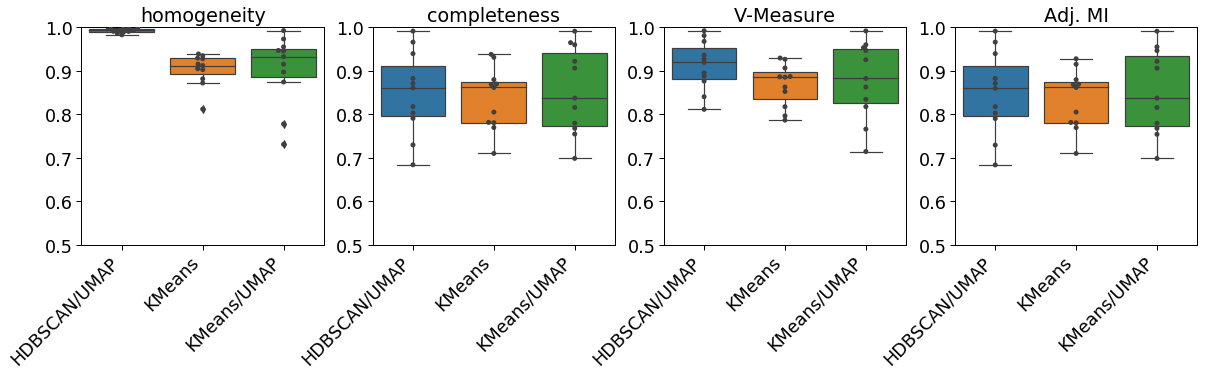

In [72]:
fig, axs = plt.subplots(ncols = 4, figsize=(20,4))

for ci, column in enumerate(["homogeneity", "completeness", "V-Measure", "Adj. MI"]):
    sns.boxplot(x="cluster", y=column, data =performance_df, ax = axs[ci])
    sns.swarmplot(x="cluster", y=column, data =performance_df, ax = axs[ci], color=".25")
    axs[ci].set_ylim([0.5,1])
    axs[ci].set_xticklabels(['HDBSCAN/UMAP', 'KMeans', 'KMeans/UMAP'], rotation=45, ha='right')
    axs[ci].set_xlabel('')
    axs[ci].set_ylabel('')
    axs[ci].set_title(column)

